Import Libraries and Load Preprocessed Data

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving
import joblib

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("-"*60)

# Load and preprocess data (same as notebook 02)
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('../data/train_FD001.txt', 
                       sep=' ', 
                       header=None, 
                       names=column_names,
                       index_col=False)

train_df = train_df.dropna(axis=1, how='all')

# Calculate RUL
max_cycles = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_cycles']

# Remove low-variance sensors
low_variance_sensors = ['sensor_1', 'sensor_5', 'sensor_6', 
                        'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_df = train_df.drop(columns=low_variance_sensors)

# Scale features
sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
setting_cols = ['setting_1', 'setting_2', 'setting_3']
features_to_scale = sensor_cols + setting_cols

scaler = MinMaxScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

# Create rolling window features
rolling_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
                   'sensor_8', 'sensor_11', 'sensor_12']
window_sizes = [5, 10]

for sensor in rolling_sensors:
    for window in window_sizes:
        train_df[f'{sensor}_rolling_mean_{window}'] = train_df.groupby('unit_number')[sensor].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

# Prepare features and target
feature_columns = [col for col in train_df.columns 
                   if col not in ['unit_number', 'time_cycles', 'max_cycles', 'RUL']]
X = train_df[feature_columns]
y = train_df['RUL']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Data loaded and preprocessed")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(feature_columns)}")
print(f"Target: RUL (range 0-{y.max()})")

Libraries imported successfully!
------------------------------------------------------------
Data loaded and preprocessed
Training samples: 16,504
Test samples: 4,127
Features: 31
Target: RUL (range 0-361)


Baseline Model - Linear Regression

------------------------------------------------------------
MODEL 1: LINEAR REGRESSION (BASELINE)
------------------------------------------------------------

Training Linear Regression model...

Training complete!

------------------------------------------------------------
PERFORMANCE METRICS
------------------------------------------------------------

Training Set:
RMSE: 43.90 cycles
MAE:  33.37 cycles
R²:   0.5975

Test Set:
RMSE: 43.38 cycles
MAE:  33.18 cycles
R²:   0.5881


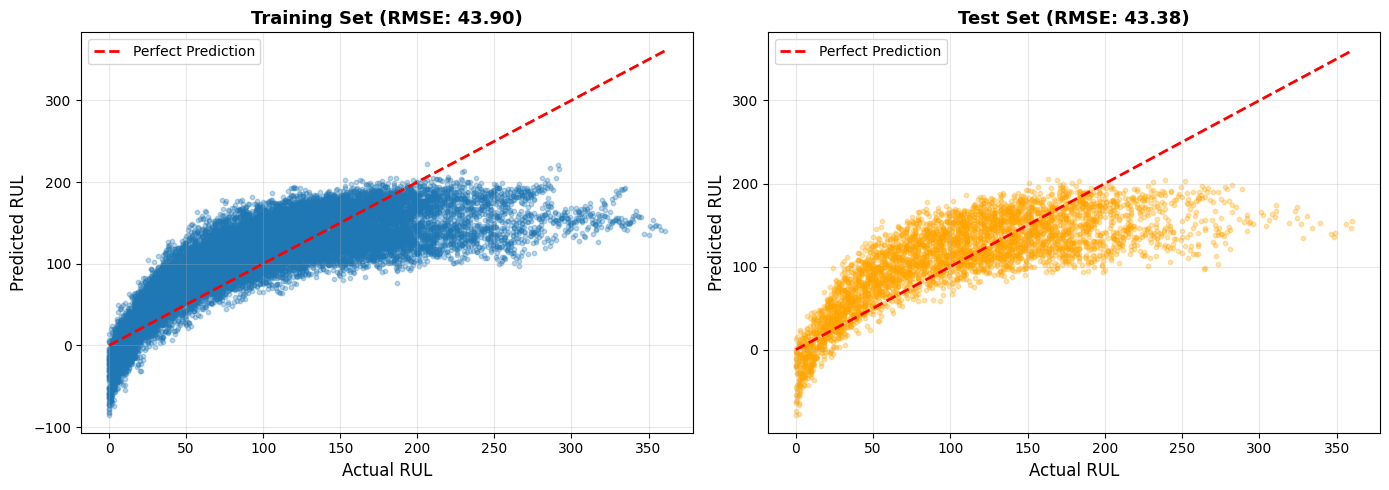


Interpretation:
- RMSE (Root Mean Squared Error): Average prediction error in cycles
- MAE (Mean Absolute Error): Average absolute error
- R² Score: How well model explains variance (1.0 = perfect)


In [3]:
print("-"*60)
print("MODEL 1: LINEAR REGRESSION (BASELINE)")
print("-"*60)

# Train Linear Regression
lr_model = LinearRegression()

print("\nTraining Linear Regression model...")
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate on training set
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)

# Evaluate on test set
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("\nTraining complete!")

print("\n" + "-"*60)
print("PERFORMANCE METRICS")
print("-"*60)
print(f"\nTraining Set:")
print(f"RMSE: {train_rmse_lr:.2f} cycles")
print(f"MAE:  {train_mae_lr:.2f} cycles")
print(f"R²:   {train_r2_lr:.4f}")

print(f"\nTest Set:")
print(f"RMSE: {test_rmse_lr:.2f} cycles")
print(f"MAE:  {test_mae_lr:.2f} cycles")
print(f"R²:   {test_r2_lr:.4f}")

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred_lr, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title(f'Training Set (RMSE: {train_rmse_lr:.2f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_lr, alpha=0.3, s=10, color='orange')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual RUL', fontsize=12)
axes[1].set_ylabel('Predicted RUL', fontsize=12)
axes[1].set_title(f'Test Set (RMSE: {test_rmse_lr:.2f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- RMSE (Root Mean Squared Error): Average prediction error in cycles")
print("- MAE (Mean Absolute Error): Average absolute error")
print("- R² Score: How well model explains variance (1.0 = perfect)")

Random Forest Regressor (Tree-Based Ensemble)

------------------------------------------------------------
MODEL 2: RANDOM FOREST
------------------------------------------------------------

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



✓ Training complete!

------------------------------------------------------------
PERFORMANCE METRICS
------------------------------------------------------------

Training Set:
  RMSE: 21.48 cycles
  MAE:  14.45 cycles
  R²:   0.9036

Test Set:
  RMSE: 36.51 cycles
  MAE:  25.51 cycles
  R²:   0.7082

------------------------------------------------------------
IMPROVEMENT OVER LINEAR REGRESSION
------------------------------------------------------------
  RMSE improvement: 6.87 cycles (15.8%)
  R² improvement: 0.1201


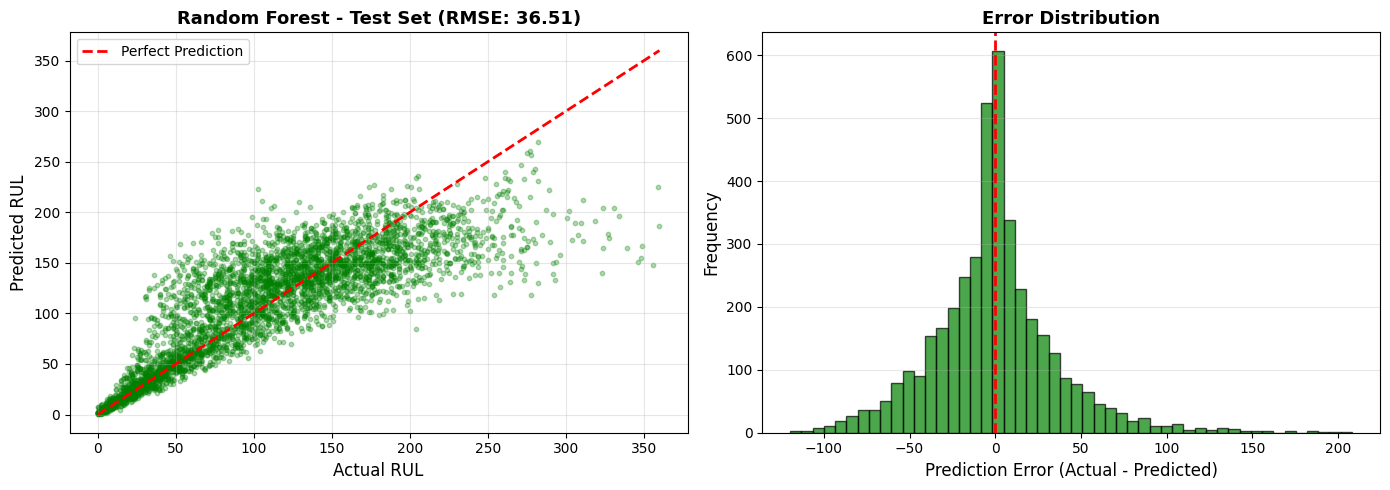

In [4]:
print("-"*60)
print("MODEL 2: RANDOM FOREST")
print("-"*60)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=20,          # Maximum tree depth
    min_samples_split=10,  # Minimum samples to split
    min_samples_leaf=5,    # Minimum samples per leaf
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    verbose=1              # Show progress
)

print("\nTraining Random Forest model...")
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n✓ Training complete!")

print("\n" + "-"*60)
print("PERFORMANCE METRICS")
print("-"*60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse_rf:.2f} cycles")
print(f"  MAE:  {train_mae_rf:.2f} cycles")
print(f"  R²:   {train_r2_rf:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {test_rmse_rf:.2f} cycles")
print(f"  MAE:  {test_mae_rf:.2f} cycles")
print(f"  R²:   {test_r2_rf:.4f}")

print("\n" + "-"*60)
print("IMPROVEMENT OVER LINEAR REGRESSION")
print("-"*60)
print(f"  RMSE improvement: {test_rmse_lr - test_rmse_rf:.2f} cycles ({((test_rmse_lr - test_rmse_rf)/test_rmse_lr*100):.1f}%)")
print(f"  R² improvement: {test_r2_rf - test_r2_lr:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test set predictions
axes[0].scatter(y_test, y_test_pred_rf, alpha=0.3, s=10, color='green')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title(f'Random Forest - Test Set (RMSE: {test_rmse_rf:.2f})', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Prediction errors
errors_rf = y_test - y_test_pred_rf
axes[1].hist(errors_rf, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Gradient Boosting (XGBoost-style)

------------------------------------------------------------
MODEL 3: GRADIENT BOOSTING
------------------------------------------------------------

Training Gradient Boosting model...
This may take 2-3 minutes...

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        4210.1119         575.0358           57.40s
         2        3736.7486         483.3033           46.21s
         3        3357.8109         433.0881           41.65s
         4        3010.9958         208.2550           39.98s
         5        2764.6376         305.3524           39.09s
         6        2557.3994         242.1673           38.15s
         7        2354.9221          87.0768           37.39s
         8        2216.4642         195.2164           36.62s
         9        2098.5585         141.2214           36.05s
        10        1995.2004         101.2868           35.74s
        20        1555.2613          67.1960           32.54s
        30        1438.7235         101

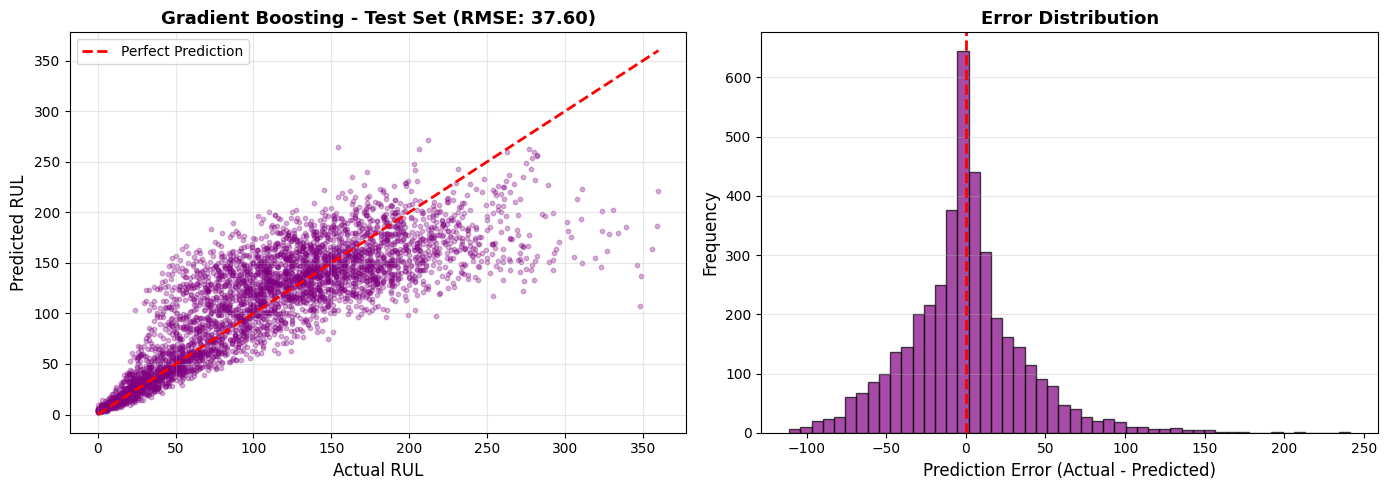

In [5]:
print("-"*60)
print("MODEL 3: GRADIENT BOOSTING")
print("-"*60)

# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=200,      # More trees for better performance
    learning_rate=0.1,     # Step size (smaller = more conservative)
    max_depth=5,           # Shallower trees than Random Forest
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,         # Use 80% of data per tree
    random_state=42,
    verbose=1              # Show progress
)

print("\nTraining Gradient Boosting model...")
print("This may take 2-3 minutes...\n")
gb_model.fit(X_train, y_train)

# Make predictions
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Evaluate
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb)
train_r2_gb = r2_score(y_train, y_train_pred_gb)

test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

print("\nTraining complete!")

print("\n" + "-"*60)
print("PERFORMANCE METRICS")
print("-"*60)
print(f"\nTraining Set:")
print(f"RMSE: {train_rmse_gb:.2f} cycles")
print(f"MAE:  {train_mae_gb:.2f} cycles")
print(f"R²:   {train_r2_gb:.4f}")

print(f"\nTest Set:")
print(f"RMSE: {test_rmse_gb:.2f} cycles")
print(f"MAE:  {test_mae_gb:.2f} cycles")
print(f"R²:   {test_r2_gb:.4f}")

print("\n" + "-"*60)
print("IMPROVEMENT OVER RANDOM FOREST")
print("-"*60)
print(f"RMSE improvement: {test_rmse_rf - test_rmse_gb:.2f} cycles")
print(f"R² improvement: {test_r2_gb - test_r2_rf:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test predictions
axes[0].scatter(y_test, y_test_pred_gb, alpha=0.3, s=10, color='purple')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title(f'Gradient Boosting - Test Set (RMSE: {test_rmse_gb:.2f})', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Error distribution
errors_gb = y_test - y_test_pred_gb
axes[1].hist(errors_gb, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Model Comparison Summary

------------------------------------------------------------
MODEL COMPARISON SUMMARY
------------------------------------------------------------

            Model  Test RMSE  Test MAE  Test R²  Train RMSE  Train R²
    Random Forest  36.511097 25.505392 0.708225   21.483249  0.903606
Gradient Boosting  37.596517 26.680908 0.690619   28.464476  0.830778
Linear Regression  43.379041 33.175168 0.588132   43.899834  0.597491

------------------------------------------------------------
WINNER: Random Forest
------------------------------------------------------------
Best Test RMSE: 36.51 cycles
Best Test R²: 0.7082

Improvement over baseline (Linear Regression):
RMSE: 6.87 cycles (15.8%)
R²: +0.1201


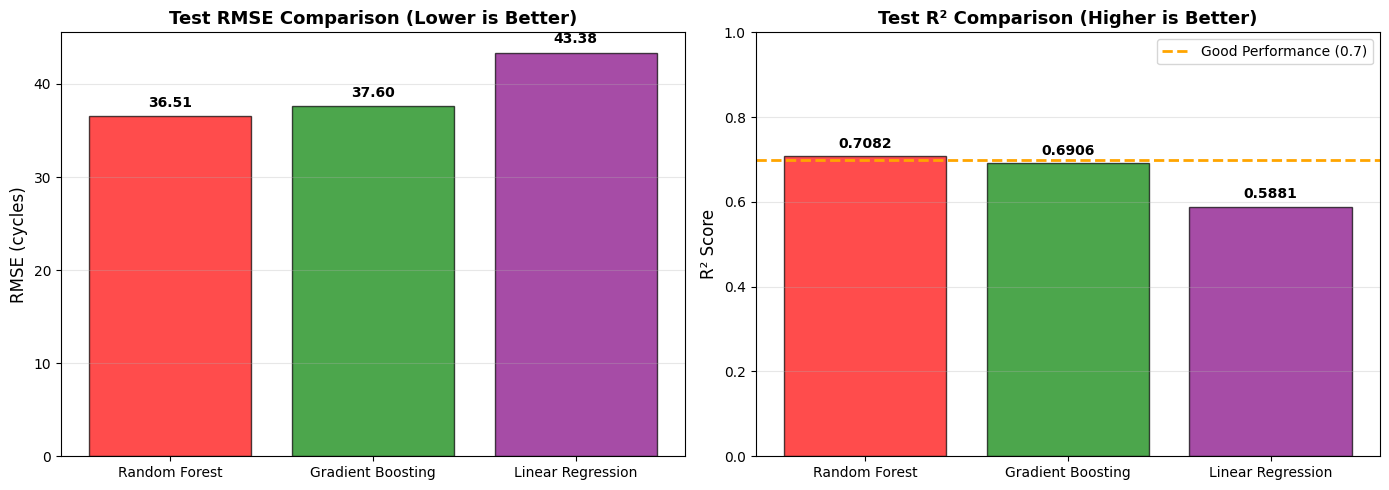

In [7]:
print("-"*60)
print("MODEL COMPARISON SUMMARY")
print("-"*60)

# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Test RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_gb],
    'Test MAE': [test_mae_lr, test_mae_rf, test_mae_gb],
    'Test R²': [test_r2_lr, test_r2_rf, test_r2_gb],
    'Train RMSE': [train_rmse_lr, train_rmse_rf, train_rmse_gb],
    'Train R²': [train_r2_lr, train_r2_rf, train_r2_gb]
})

# Sort by Test RMSE (lower is better)
results = results.sort_values('Test RMSE')

print("\n" + results.to_string(index=False))

print("\n" + "-"*60)
print("WINNER: Random Forest")
print("-"*60)
print(f"Best Test RMSE: {test_rmse_rf:.2f} cycles")
print(f"Best Test R²: {test_r2_rf:.4f}")
print(f"\nImprovement over baseline (Linear Regression):")
print(f"RMSE: {test_rmse_lr - test_rmse_rf:.2f} cycles ({((test_rmse_lr - test_rmse_rf)/test_rmse_lr*100):.1f}%)")
print(f"R²: +{test_r2_rf - test_r2_lr:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
models = results['Model'].tolist()
test_rmse_values = results['Test RMSE'].tolist()
colors = ['red', 'green', 'purple']

axes[0].bar(models, test_rmse_values, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('RMSE (cycles)', fontsize=12)
axes[0].set_title('Test RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_rmse_values):
    axes[0].text(i, v + 1, f'{v:.2f}', ha='center', fontweight='bold')

# R² comparison
r2_values = results['Test R²'].tolist()

axes[1].bar(models, r2_values, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].set_title('Test R² Comparison (Higher is Better)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Good Performance (0.7)')
axes[1].legend()
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Save the Best Model

In [8]:
import os

print("-"*60)
print("SAVING BEST MODEL")
print("-"*60)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the Random Forest model
model_path = '../models/random_forest_model.pkl'
joblib.dump(rf_model, model_path)
print(f"\nRandom Forest model saved to: {model_path}")

# Save the scaler (needed for preprocessing new data)
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save feature names (for dashboard)
feature_path = '../models/feature_names.pkl'
joblib.dump(feature_columns, feature_path)
print(f"Feature names saved to: {feature_path}")

# Test loading the model
print("\n" + "-"*60)
print("TESTING MODEL LOADING")
print("-"*60)

loaded_model = joblib.load(model_path)
test_prediction = loaded_model.predict(X_test[:5])
print("\nTest prediction on first 5 samples:")
print(f"Actual RUL: {y_test.iloc[:5].values}")
print(f"Predicted RUL: {np.round(test_prediction, 2)}")

print("\nModel loads and predicts successfully!")

# Model summary
print("\n" + "-"*60)
print("-"*60)
print(f"""
✈️ Aircraft Predictive Maintenance System

Model: Random Forest Regressor
Performance: 
  - Test RMSE: {test_rmse_rf:.2f} cycles (~{test_rmse_rf:.0f} flight operations)
  - Test MAE: {test_mae_rf:.2f} cycles
  - Test R²: {test_r2_rf:.4f}

Features Used: {len(feature_columns)}
  - 14 sensor readings
  - 3 operational settings  
  - 14 rolling window features

Training Data: {len(X_train):,} samples from 100 engines

Use Case:
  Given current sensor readings, predict how many flight cycles
  remain before engine failure, enabling proactive maintenance
  scheduling and preventing unexpected breakdowns.
  
Business Impact:
  - Average error of ~37 cycles provides 30-40 flight buffer
  - Enables maintenance planning weeks in advance
  - Reduces unscheduled downtime
  - Improves safety and operational efficiency
""")

------------------------------------------------------------
SAVING BEST MODEL
------------------------------------------------------------

Random Forest model saved to: ../models/random_forest_model.pkl
Scaler saved to: ../models/scaler.pkl
Feature names saved to: ../models/feature_names.pkl

------------------------------------------------------------
TESTING MODEL LOADING
------------------------------------------------------------

Test prediction on first 5 samples:
Actual RUL: [135   2 217   0 178]
Predicted RUL: [110.91   5.28 180.97   1.99 163.06]

Model loads and predicts successfully!

------------------------------------------------------------
------------------------------------------------------------

✈️ Aircraft Predictive Maintenance System

Model: Random Forest Regressor
Performance: 
  - Test RMSE: 36.51 cycles (~37 flight operations)
  - Test MAE: 25.51 cycles
  - Test R²: 0.7082

Features Used: 31
  - 14 sensor readings
  - 3 operational settings  
  - 14 rolling 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
